# Install and Import


In [1]:
!pip -q install summa
!pip -q install beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from importlib.metadata import version
import nltk
from nltk.corpus import stopwords
import tensorflow
import summa
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

# 불용어 다운로드
nltk.download('stopwords')

# Warnings 없애기
import warnings
warnings.filterwarnings(action='ignore')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.18.0
2.2.2
1.2.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
80726,Players change underwear at Wimbledon since it...,"Boys' doubles top seeds, Hungary's Zsombor Pir..."
2254,Gujarat to implement 10% quota for general cat...,Gujarat will become the first state to impleme...
20576,Toyota's India plant is the company's greenest...,Toyota's Bidadi plant near Bengaluru has been ...
82914,Saudi Arabia's deposed crown prince 'under pal...,Saudi Arabia's recently deposed Crown Prince M...
2980,"Pictures show Isha Ambani, Anand Piramal at th...",Almost a month after they got married in Mumba...
38802,Cannot believe what one video did for us: Suni...,Referring to the video he shared urging the fa...
67792,"2 died, 20 injured in Terrace collapse during ...",At least 2 have died and nearly 20 people have...
15320,"Apple faces lawsuit over iMessage, FaceTime en...",Apple has been hit with a lawsuit by Finnish c...
75986,Japan could intercept a Guam-bound N Korea mis...,Japan could legally intercept a North Korean m...
69493,Yuvraj only player to hit 6 sixes in 1 over of...,Yuvraj Singh is the only player to hit six six...


# 데이터 전처리

## Clean

null sample확인

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


null 값 없음

중복데이터 확인

In [ ]:
print('헤드라인 중복 개수: ', len(data) - data['headlines'].nunique())
print('헤드라인 중복 제거 후 개수: ',data['headlines'].nunique())
print('텍스트 중복 개수: ', len(data) - data['text'].nunique())
print('텍스트 중복 제거 후 개수: ',data['text'].nunique())

헤드라인 중복 개수:  121
헤드라인 중복 제거 후 개수:  98280
텍스트 중복 개수:  41
텍스트 중복 제거 후 개수:  98360


텍스트 기준 중복 제거

In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


정규화 사전

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 확인

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

전처리 실행

In [ ]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub('\'','', sentence) # 따옴표 " 제거

    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거.
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환 - 숫자도?
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
# text 전처리 (불용어 제거 O)
data["clean_text"] = data["text"].apply(lambda x: preprocess_sentence(x))

# headline 전처리 (불용어 제거 X)
data["clean_headlines"] = data["headlines"].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

data.head()

,headlines,text,clean_text,clean_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit bs pg program ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led indias match ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


전처리 후 생긴 null 값 제거

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


⚠️ 로컬 저장하여 전처리 중복실행 방지(시간 오래걸림!)

In [ ]:
data.to_csv('./data/clean_data.csv', index=False)

NameError: name 'data' is not defined

In [ ]:
# data = pd.read_csv('./data/clean_data.csv')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/data/clean_data.csv')

data.head()

,headlines,text,clean_text,clean_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit bs pg program ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led indias match ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


# Train, Test Split

샘플 최대 길이 정하기

In [ ]:
def text_head_plot(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    text_len = [len(i.split()) for i in data['clean_text']]
    headline_len = [len(i.split()) for i in data['clean_headlines']]

    print(f"text 최소, 최대, 평균길이\n{np.min(text_len)}, {np.max(text_len)}, {np.mean(text_len)}")
    print(f"headline 최소, 최대, 평균길이\n{np.min(headline_len)}, {np.max(headline_len)}, {np.mean(headline_len)}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(text_len, ax=axes[0])
    sns.histplot(headline_len, ax=axes[1])
    axes[0].set_title("Text")
    axes[1].set_title("Headline")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.boxplot(text_len, ax=axes[0])
    sns.boxplot(headline_len, ax=axes[1])
    axes[0].set_title("Text")
    axes[1].set_title("Headline")
    plt.tight_layout()
    plt.show()

def high_below_threshold_len(min_len,max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(min_len<=len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상 %s 이하인 샘플의 비율: %s'%(min_len,max_len, (cnt / len(nested_list))))


text 최소, 최대, 평균길이
1, 60, 35.25167751118341
headline 최소, 최대, 평균길이
1, 15, 9.265982106547376


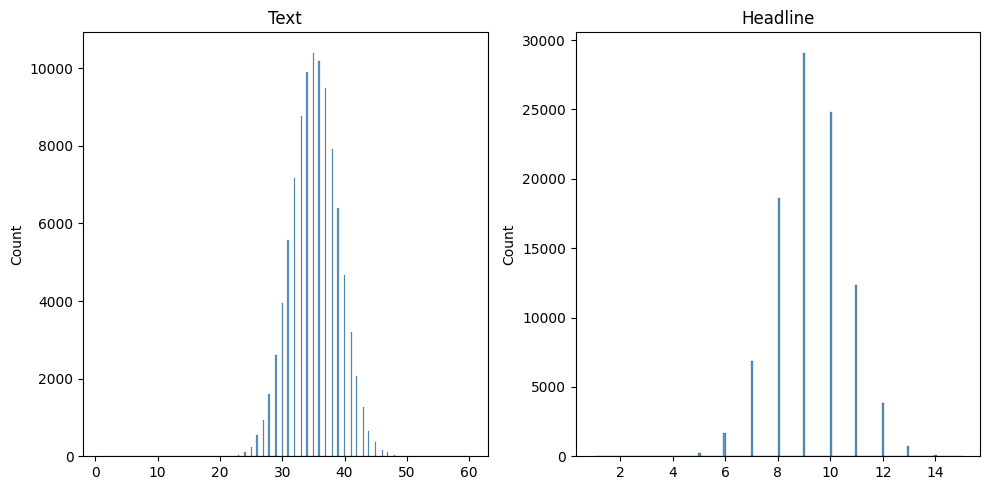

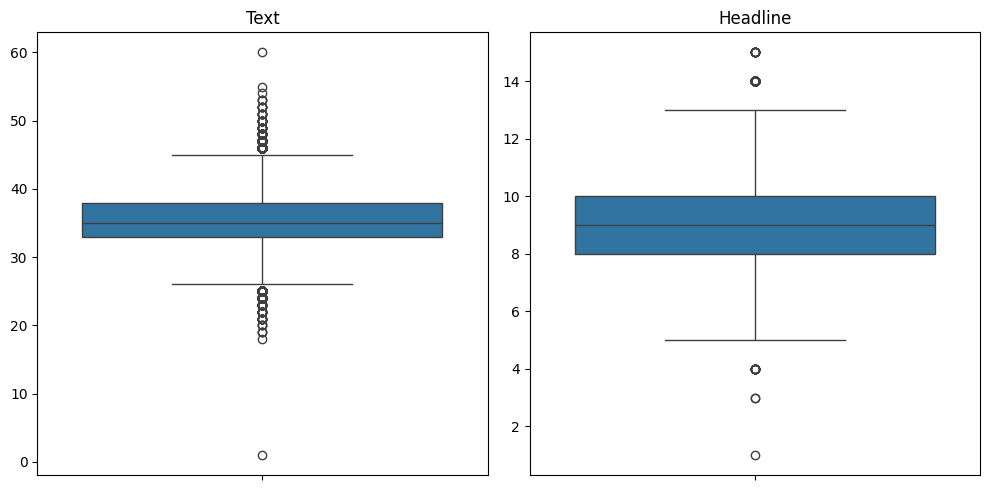

In [ ]:
text_head_plot(data)

정규분포형태이므로 최소, 최대 설정한다

In [ ]:
text_min_len = 10
text_max_len = 50
head_min_len = 5
head_max_len = 13

high_below_threshold_len(text_min_len,text_max_len, data['clean_text'])
high_below_threshold_len(head_min_len,head_max_len,  data['clean_headlines'])

전체 샘플 중 길이가 10 이상 50 이하인 샘플의 비율: 0.9998169987799919
전체 샘플 중 길이가 5 이상 13 이하인 샘플의 비율: 0.9987698251321675


In [ ]:
sampled_data = data[
    (data['clean_text'].apply(lambda x: text_min_len <= len(x.split()) <= text_max_len)) &
    (data['clean_headlines'].apply(lambda x: head_min_len <= len(x.split()) <= head_max_len))
]
sampled_data.head()

,headlines,text,clean_text,clean_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit bs pg program ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led indias match ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


headlines에 시작, 종료 토큰을 추가한다.

In [ ]:
sampled_data['decoder_input'] = sampled_data['clean_headlines'].apply(lambda x : 'sostoken '+ x)
sampled_data['decoder_target'] = sampled_data['clean_headlines'].apply(lambda x : x + ' eostoken')

# 결과 확인
sampled_data[['clean_headlines', 'decoder_input', 'decoder_target']].head()

,clean_headlines,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led indias match ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led indias match ...
3,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


디코더 부분 input, terget data 처리 완료

인코더용 입력, 디코더용 입력, 디코더용 레이블 재저장

In [ ]:
encoder_input = np.array(sampled_data['clean_text']) # 인코더의 입력
decoder_input = np.array(sampled_data['decoder_input']) # 디코더의 입력
decoder_target = np.array(sampled_data['decoder_target']) # 디코더의 레이블

print(encoder_input.shape,decoder_input.shape,decoder_target.shape)
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_target[:3])

(98222,) (98222,) (98222,)
['saurav kant alumnus upgrad iiit bs pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrads degree career support helped transition data scientist tech mahindra salary hike upgrads online power learning powered lakh careers'
 'kunal shahs credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharmas captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history']
['sostoken upgrad learner switches to career in ml al with salary hike'
 'sostoken delhi techie wins free food from swiggy for one y

훈련, 테스트 split을 위해서 indices를 섞어준다

In [ ]:
# indices를 이용해 데이터를 섞고 split한다,
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[45321 84492 48409 ... 57018 58809 30965]


test 시의 data leakeage를 피하기 위해 validation set만든다.

In [ ]:
# 데이터 섞는다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 훈련 데이터 0.7
n_of_val = int(len(encoder_input)*0.2)
n_total = len(encoder_input)
n_test = int(n_total * 0.15)
n_val = int(n_total * 0.15)
print('Test, Val 데이터의 수 :', n_of_val)

# split
encoder_input_train = encoder_input[:-(n_test + n_val)]
decoder_input_train = decoder_input[:-(n_test + n_val)]
decoder_target_train = decoder_target[:-(n_test + n_val)]

encoder_input_val = encoder_input[-(n_test + n_val):-n_test]
decoder_input_val = decoder_input[-(n_test + n_val):-n_test]
decoder_target_val = decoder_target[-(n_test + n_val):-n_test]

encoder_input_test = encoder_input[-n_test:]
decoder_input_test = decoder_input[-n_test:]
decoder_target_test = decoder_target[-n_test:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('Valid 데이터의 개수 :', len(encoder_input_val))
print('Valid 레이블의 개수 :', len(decoder_input_val))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

Test, Val 데이터의 수 : 19644
훈련 데이터의 개수 : 68756
훈련 레이블의 개수 : 68756
Valid 데이터의 개수 : 14733
Valid 레이블의 개수 : 14733
테스트 데이터의 개수 : 14733
테스트 레이블의 개수 : 14733


# Encoding

인코더의 토크나이저

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69624
등장 빈도가 6번 이하인 희귀 단어의 수: 48257
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21367
단어 집합에서 희귀 단어의 비율: 69.31086981500631
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.0085475410553055


In [ ]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[48, 147, 7383, 160, 492, 314, 706, 1387, 340, 643, 19863, 1240, 5038, 3981, 4333, 2693, 465, 1431, 3563, 358, 17, 65, 1674, 3783, 2590, 15242, 2572, 643, 378, 706, 1051, 492, 2251, 41, 3191, 8163, 1565, 340, 643], [3982, 81, 1685, 1191, 84, 758, 4, 2859, 1592, 43, 110, 57, 2924, 652, 413, 165, 502, 414, 37, 887, 7056, 671, 37, 119, 2064, 10, 1191, 1, 26, 536, 442, 850, 78, 2031, 1947, 163, 252, 165], [701, 254, 299, 75, 18, 9284, 701, 3476, 3452, 1631, 5655, 3248, 39, 106, 324, 337, 93, 1030, 299, 142, 21, 1, 701, 3127, 106, 102, 384, 1130, 608, 3452, 6, 874, 246, 1018, 1059]]


디코더의 토크나이저

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30412
등장 빈도가 5번 이하인 희귀 단어의 수: 20436
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9976
단어 집합에서 희귀 단어의 비율: 67.19715901617782
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.495218990778216


In [ ]:
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
#train
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
#test
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
#validation
decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])


print('val')
print('decoder ',decoder_input_val[:5])
print('decoder ',decoder_target_val[:5])

input
input  [[1, 3661, 436, 357, 438, 526, 344, 10, 6387], [1, 11, 30, 21, 212, 112, 1435, 74, 45, 167, 604, 1116], [1, 29, 1531, 92, 4, 1946, 7, 2578], [1, 33, 27, 3, 1021, 1098, 370, 316, 8358, 219], [1, 120, 1635, 5754, 537, 37, 346, 3193, 521]]
target
decoder  [[3661, 436, 357, 438, 526, 344, 10, 6387, 2], [11, 30, 21, 212, 112, 1435, 74, 45, 167, 604, 1116, 2], [29, 1531, 92, 4, 1946, 7, 2578, 2], [33, 27, 3, 1021, 1098, 370, 316, 8358, 219, 2], [120, 1635, 5754, 537, 37, 346, 3193, 521, 2]]
val
decoder  [[1, 45, 38, 419, 7, 111, 3, 339, 421, 583], [1, 3023, 4507, 254, 4896, 6, 2186, 102, 23, 46, 106], [1, 340, 123, 156, 3, 211, 7, 2172, 8, 338, 123], [1, 361, 5117, 24, 200, 295, 7, 38, 654, 5255, 483], [1, 8772, 19, 20, 164, 1620, 5, 2238, 1501, 6053]]
decoder  [[45, 38, 419, 7, 111, 3, 339, 421, 583, 2], [3023, 4507, 254, 4896, 6, 2186, 102, 23, 46, 106, 2], [340, 123, 156, 3, 211, 7, 2172, 8, 338, 123, 2], [361, 5117, 24, 200, 295, 7, 38, 654, 5255, 483, 2], [8772, 19, 20, 164

희귀단어에 의한 null데이터 삭제

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
drop_val = [index for index, sentence in enumerate(decoder_input_val) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 Validation 데이터의 개수 :', len(drop_val))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_val = [sentence for index, sentence in enumerate(encoder_input_val) if index not in drop_val]
decoder_input_val = [sentence for index, sentence in enumerate(decoder_input_val) if index not in drop_val]
decoder_target_val = [sentence for index, sentence in enumerate(decoder_target_val) if index not in drop_val]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))
print('Validation 데이터의 개수 :', len(encoder_input_val))
print('Validation 레이블의 개수 :', len(decoder_input_val))


삭제할 훈련 데이터의 개수 : 0
삭제할 Validation 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68756
훈련 레이블의 개수 : 68756
테스트 데이터의 개수 : 14733
테스트 레이블의 개수 : 14733
Validation 데이터의 개수 : 14733
Validation 레이블의 개수 : 14733


post padding 진행

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_input_val= pad_sequences(decoder_input_val, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')

decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

print('인코더의 입력의 크기 :', encoder_input_train.shape)
print('디코더의 입력의 크기 :', decoder_input_train.shape)
print('디코더의 레이블의 크기 :', decoder_target_train.shape)

인코더의 입력의 크기 : (68756, 50)
디코더의 입력의 크기 : (68756, 13)
디코더의 레이블의 크기 : (68756, 13)


In [6]:
import ast
def to_list(df, encoder_input, decoder_input, decoder_target):
    df = df.reset_index(drop=True).copy()
    df["encoder_input"] = encoder_input.tolist()
    df["decoder_input"] = decoder_input.tolist()
    df["decoder_target"] = decoder_target.tolist()
    return df

def parse_sequences(df):
    # csv 읽어오면 넘파이배열로 파싱해줘야 함
    encoder_input = np.array(df["encoder_input"].apply(ast.literal_eval).tolist())
    decoder_input = np.array(df["decoder_input"].apply(ast.literal_eval).tolist())
    decoder_target = np.array(df["decoder_target"].apply(ast.literal_eval).tolist())
    return encoder_input, decoder_input, decoder_target

In [ ]:
import os
import pickle

test_indices = indices[-n_test:]
val_indices = indices[-(n_test + n_val):-n_test]
train_indices = indices[:-(n_test + n_val)]

train_df = to_list(data.iloc[train_indices], encoder_input_train, decoder_input_train, decoder_target_train)
val_df = to_list(data.iloc[val_indices], encoder_input_val, decoder_input_val, decoder_target_val)
test_df = to_list(data.iloc[test_indices], encoder_input_test, decoder_input_test, decoder_target_test)

# CSV로 저장
save_dir = "/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/split_data/"
os.makedirs(save_dir, exist_ok=True)

train_df.to_csv(save_dir + "train.csv", index=False)
val_df.to_csv(save_dir + "val.csv", index=False)
test_df.to_csv(save_dir + "test.csv", index=False)

train_df.head()

,headlines,text,clean_text,clean_headlines,encoder_input,decoder_input,decoder_target
0,Four-time Tripura CM Manik Sarkar submits resi...,Four-time Tripura Chief Minister Manik Sarkar ...,four time tripura chief minister manik sarkar ...,four time tripura cm manik sarkar submits resi...,"[48, 147, 7383, 160, 492, 314, 706, 1387, 340,...","[1, 3661, 436, 357, 438, 526, 344, 10, 6387, 0...","[3661, 436, 357, 438, 526, 344, 10, 6387, 2, 0..."
1,Don't tell women what to wear: Kriti on Priyan...,"Actress Kriti Sanon, reacting to the row over ...",actress kriti sanon reacting row priyanka chop...,dont tell women what to wear kriti on priyanka...,"[3982, 81, 1685, 1191, 84, 758, 4, 2859, 1592,...","[1, 11, 30, 21, 212, 112, 1435, 74, 45, 167, 6...","[11, 30, 21, 212, 112, 1435, 74, 45, 167, 604,..."
2,Miss World Manushi Chhillar features on 'Cosmo...,Miss World Manushi Chhillar has featured on th...,miss world manushi chhillar featured cover feb...,miss world manushi chhillar features on cosmop...,"[701, 254, 299, 75, 18, 9284, 701, 3476, 3452,...","[1, 29, 1531, 92, 4, 1946, 7, 2578, 0, 0, 0, 0...","[29, 1531, 92, 4, 1946, 7, 2578, 2, 0, 0, 0, 0..."
3,U'khand CM spent Ã¢ÂÂ¹68.5 lakh govt funds on...,Uttarakhand Chief Minister Trivendra Singh Raw...,uttarakhand chief minister trivendra singh raw...,ukhand cm spent lakh govt funds on snacks for ...,"[17586, 14594, 171, 7, 11, 4458, 1344, 226, 18...","[1, 33, 27, 3, 1021, 1098, 370, 316, 8358, 219...","[33, 27, 3, 1021, 1098, 370, 316, 8358, 219, 2..."
4,I'm disappointed with Infosys board: Founder N...,Infosys Founder Narayana Murthy on Tuesday exp...,infosys founder narayana murthy tuesday expres...,im disappointed with infosys board founder nar...,"[427, 96, 20, 320, 905, 9477, 15910, 1003, 231...","[1, 120, 1635, 5754, 537, 37, 346, 3193, 521, ...","[120, 1635, 5754, 537, 37, 346, 3193, 521, 2, ..."


In [ ]:
encoder_input_train, decoder_input_train, decoder_target_train = parse_sequences(train_df)
encoder_input_val, decoder_input_val, decoder_target_val = parse_sequences(val_df)
encoder_input_test, decoder_input_test, decoder_target_test = parse_sequences(test_df)

print(encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape)

(68756, 50) (68756, 13) (68756, 13)


# Build Model

In [27]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

In [32]:
text_min_len = 10
text_max_len = 50
head_min_len = 5
head_max_len = 13
src_vocab = 20000
tar_vocab = 9500

인코더

In [33]:
embedding_dim = 128
hidden_size = 256

# 인코더 입력
encoder_inputs = Input(shape=(text_max_len,))

# 임베딩 레이어
enc_emb = Embedding(input_dim=src_vocab, output_dim=embedding_dim)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

디코더

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

어텐션 레이어 추가

In [36]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model_attn = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  2,560,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 128) │  1,216,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │    394,240 │ embedding_2[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_4[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  4,873,500 │ concat_layer[0][… │
│                     │ 9500)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,488,860 (40.01 MB)

 Trainable params: 10,488,860 (40.01 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

모델 컴파일 후 학습 시작

In [ ]:
model_attn = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

optimizer = RMSprop(learning_rate=0.005)
model_attn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model_attn.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
          batch_size=256, callbacks=[es,mc], epochs=100)

Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 4.5510
Epoch 1: val_loss improved from inf to 4.27744, saving model to /content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 69s 243ms/step - loss: 4.5505 - val_loss: 4.2774
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 4.1603
Epoch 2: val_loss improved from 4.27744 to 4.12057, saving model to /content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - loss: 4.1602 - val_loss: 4.1206
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 3.9495
Epoch 3: val_loss improved from 4.12057 to 3.97749, saving model to /content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 66s 246ms/step - loss: 3.9495 - val_loss: 3.9775
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 3.7777
Epoch 4: val_loss improved from 3.97749 

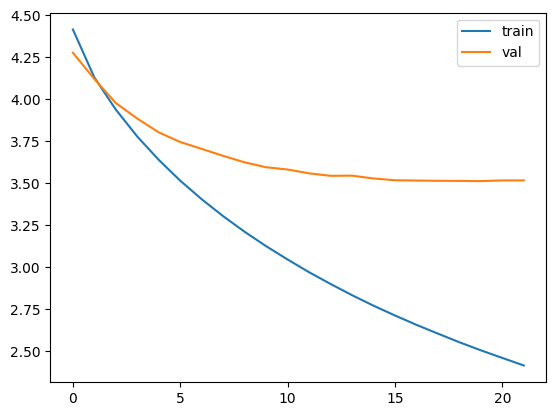

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [12]:
# 저장된 best model 불러오기
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras'
model_attn = load_model(model_path)

# Inference Model

In [17]:
import pickle
# 토크나이저 로드
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/split_data/"

with open(tokenizer_path + "src_tokenizer.pkl", 'rb') as f:
    src_tokenizer = pickle.load(f)

with open(tokenizer_path + "tar_tokenizer.pkl", 'rb') as f:
    tar_tokenizer = pickle.load(f)

In [18]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [37]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [38]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (head_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Model Test (Abstractive Summarization) &Extractive Summarization

In [40]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2head(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp += tar_index_to_word[i] + ' '
    return temp.strip()

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
save_dir = "/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/split_data/"

test_df = pd.read_csv(save_dir+"test.csv")
encoder_input_test, decoder_input_test, decoder_target_test = parse_sequences(test_df)

- 이미 전처리가 완료된 데이터로 했더니 summa에서 제대로 요약을 못하고 있었음.
- 추출적 요약 시에는 전처리 안 한 상태로 해야하므로 수정함

In [ ]:
from summa.summarizer import summarize

sampled_data['text'] = sampled_data['text'].astype(str)
test_start_index = len(encoder_input_train) + len(encoder_input_val)

for i in range(20):
    original_idx = indices[test_start_index + i]

    original_text = str(sampled_data['text'].iloc[original_idx])
    cleaned_text = sampled_data['clean_text'].iloc[original_idx]
    original_headline = sampled_data['headlines'].iloc[original_idx]

    # Extractive 요약
    try:
        extractive = summarize(original_text, words=20)
        if not extractive.strip():
            extractive = "[❕ 추출 요약 없음 - 문장 수 부족]"
    except:
        extractive = "[❌ summa 요약 실패]"

    # Abstractive 요약
    try:
        abstractive = decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).strip()
    except:
        abstractive = "[❌ decode_sequence 실패]"

    reference = seq2head(decoder_target_test[i])

    print(f"🔢 샘플 {i} (원본 index: {original_idx})")
    print(f"🟢 원문 텍스트:\n{original_text}\n")
    print(f" 전처리된 텍스트:\n{cleaned_text}\n")
    print(f" 원본 헤드라인:\n{original_headline}\n")
    print(f" 전처리된 헤드라인:\n{reference}\n")
    print(f"🔴 Abstractive 요약 (모델):\n{abstractive}\n")
    print(f"🟡 Extractive 요약 (summa):\n{extractive}\n")
    print("=" * 70)


🔢 샘플 50 (원본 index: 839)
🟢 원문 텍스트:
Presenting an ode to friendship that lasts through thick and thin, 'Four More Shots Please' traces the journey of 4 women best friends who face their highs and lows together in the city of Mumbai and more often than not, end the day with some shots. The show will be streaming on Amazon Prime Video from January 25. 

 전처리된 텍스트:
presenting ode friendship lasts thick thin four shots please traces journey women best friends face highs lows together city mumbai often end day shots show streaming amazon prime video january

 원본 헤드라인:
'Four More Shots Please' follows lives of 4 women best friends

 전처리된 헤드라인:
four more shots please follows lives of women best friends

🔴 Abstractive 요약 (모델):
model apologises for wearing on the day

🟡 Extractive 요약 (summa):
[❕ 추출 요약 없음 - 문장 수 부족]

🔢 샘플 51 (원본 index: 4715)
🟢 원문 텍스트:
Scientists at Israel's Tel Aviv University have developed bioplastics derived from microbes that feed on seaweed. The single-celled microbes, which 

🔢 샘플 59 (원본 index: 2454)
🟢 원문 텍스트:
Ayushmann Khurrana, on being asked if he'd ever publish a book of poems, said, "I would love to do it...What I write, I want to share with people. It's an artistic yearning." "Hopefully, the book will happen with time...It's just that I need to churn out more shayaris because most of them are out in the public domain," he added. 

 전처리된 텍스트:
ayushmann khurrana asked hed ever publish book poems said would love write want share people artistic yearning hopefully book happen time need churn shayaris public domain added

 원본 헤드라인:
I would love to do it: Ayushmann on writing a book of poems

 전처리된 헤드라인:
would love to do it ayushmann on writing book of

🔴 Abstractive 요약 (모델):
have been about my life ayushmann on quitting

🟡 Extractive 요약 (summa):
Ayushmann Khurrana, on being asked if he'd ever publish a book of poems, said, "I would love to do it...What I write, I want to share with people.

🔢 샘플 60 (원본 index: 83471)
🟢 원문 텍스트:
Retail giant and US' largest c

🔢 샘플 67 (원본 index: 52465)
🟢 원문 텍스트:
US President Donald Trump has cancelled his visit to the UK next month where he was supposed to open the new American embassy. Trump blamed former US President Barack Obama's administration for his decision, saying the relocation of the embassy was a "bad deal". Estimated to be worth over Ã¢ÂÂ¹6,300 crore, the embassy is reportedly the world's most expensive one.

 전처리된 텍스트:
us president donald trump cancelled visit uk next month supposed open new american embassy trump blamed former us president barack obamas administration decision saying relocation embassy bad deal estimated worth crore embassy reportedly worlds expensive one

 원본 헤드라인:
Trump cancels UK visit to protest Obama's 'bad embassy deal'

 전처리된 헤드라인:
trump cancels uk visit to protest obamas bad embassy deal

🔴 Abstractive 요약 (모델):
trump to have quit us for us presidents report

🟡 Extractive 요약 (summa):
US President Donald Trump has cancelled his visit to the UK next month where he was su

🔢 샘플 75 (원본 index: 43172)
🟢 원문 텍스트:
Pakistan will not send back its High Commissioner to India, Sohail Mahmood, until the current tensions between the two nations are resolved, officials said. Both India and Pakistan have accused each other of harassment and ill-treatment of their envoys. This is the first time since 2002 that Pakistan has called back its envoy from India in this regard.

 전처리된 텍스트:
pakistan send back high commissioner india sohail mahmood current tensions two nations resolved officials said india pakistan accused harassment ill treatment envoys first time since pakistan called back envoy india regard

 원본 헤드라인:
Won't send back envoy to India until tensions resolved: Pak

 전처리된 헤드라인:
wont send back envoy to india until tensions resolved pak

🔴 Abstractive 요약 (모델):
india india agree to india india in india report

🟡 Extractive 요약 (summa):
This is the first time since 2002 that Pakistan has called back its envoy from India in this regard.

🔢 샘플 76 (원본 index: 55745)
🟢 원문 

🔢 샘플 83 (원본 index: 6745)
🟢 원문 텍스트:
South Korean payment services startup Toss has raised $80 million in a funding round at a $1.2-billion valuation, entering South KoreaÃ¢ÂÂs billion-dollar club. The round was led by US-based Kleiner Perkins and Ribbit Capital, and existing investors Altos Ventures and PayPal also participated. Toss was launched as a peer-to-peer payment service in 2015 by former dentist SG Lee.

 전처리된 텍스트:
south korean payment services startup toss raised million funding round billion valuation entering south korea billion dollar club round led us based kleiner perkins ribbit capital existing investors altos ventures paypal also participated toss launched peer peer payment service former dentist sg lee

 원본 헤드라인:
Payment service Toss enters S KoreaÃ¢ÂÂs billion-dollar club

 전처리된 헤드라인:
payment service toss enters korea billion dollar club

🔴 Abstractive 요약 (모델):
us startup raises mn from valuation to raise mn

🟡 Extractive 요약 (summa):
South Korean payment services

🔢 샘플 91 (원본 index: 68427)
🟢 원문 텍스트:
YouTuber JerryRigEverything uploaded a video earlier this week testing the iPhone 8's durability. Apart from testing if the phone was bend-proof, he subjected the iPhone 8 to a scratch test on the display, camera, and the back glass. He also used a lighter on the display which blackened out the pixels for a while but recovered after cooling down.

 전처리된 텍스트:
youtuber jerryrigeverything uploaded video earlier week testing iphone durability apart testing phone bend proof subjected iphone scratch test display camera back glass also used lighter display blackened pixels recovered cooling

 원본 헤드라인:
Video shows iPhone 8 being tested for durability

 전처리된 헤드라인:
video shows iphone being tested for

🔴 Abstractive 요약 (모델):
iphone in iphone ipad in us

🟡 Extractive 요약 (summa):
Apart from testing if the phone was bend-proof, he subjected the iPhone 8 to a scratch test on the display, camera, and the back glass.

🔢 샘플 92 (원본 index: 29087)
🟢 원문 텍스트:
A surgeon in 

🔢 샘플 99 (원본 index: 48082)
🟢 원문 텍스트:
Congress President Rahul Gandhi on Monday slammed RSS chief Mohan Bhagwat, saying that he has disrespected the country's Army and martyrs. Bhagwat on Sunday said that unlike the Army which takes 6-7 months to prepare the personnel, the RSS will prepare a military force in 3 days. "The RSS Chief's speech is an insult to every Indian," Rahul Gandhi tweeted.

 전처리된 텍스트:
congress president rahul gandhi monday slammed rss chief mohan bhagwat saying disrespected countrys army martyrs bhagwat sunday said unlike army takes months prepare personnel rss prepare military force days rss chiefs speech insult every indian rahul gandhi tweeted

 원본 헤드라인:
Shame on Mohan Bhagwat for disrespecting Army: Rahul Gandhi

 전처리된 헤드라인:
shame on mohan bhagwat for disrespecting army rahul gandhi

🔴 Abstractive 요약 (모델):
rahul gandhi is hindu india rss chief

🟡 Extractive 요약 (summa):
Congress President Rahul Gandhi on Monday slammed RSS chief Mohan Bhagwat, saying that he has di

# 회고
- extractive는 어느정도 문장이 길어야 잘 추출되는 것 같다.
- 문장이 짧으면 요약이 안되는 경우가 나오기도 하고, 추출 ratio나 word수가 작으면 실패한다.
- abstractive의 경우 키워드를 조금씩 추출하는 것 같다. 그러나 요약 문장의 문법이 많이 어색해보인다.
- 학습데이터의 품질에 영향이 커 보인다.

